In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import os
os.chdir("/content/gdrive/My Drive/STAT_440/nft")

In [ ]:
!ls

data_current  models.ipynb  preprocessing.ipynb


In [ ]:
!pip3 install numpy pandas scikit-learn seaborn matplotlib xgboost Pillow scikit-image feature-engine scipy tqdm

In [182]:
import pandas as pd
import numpy as np
# Models
from sklearn.svm import SVR
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
# Other
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from operator import itemgetter
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline


In [304]:
'''
Load data.
'''
PATH = './data_current/'
TRAIN_FILE = 'XYtr_updated_reduced_dim.csv'
TEST_FILE = 'Xte_updated_reduced_dim.csv'
PRED_FILE = 'pred.csv'
df_train = pd.read_csv(PATH + TRAIN_FILE, index_col='id')
df_test = pd.read_csv(PATH + TEST_FILE, index_col='id')
df_preds = pd.read_csv(PATH + PRED_FILE, index_col='id')



In [276]:
'''
Create the prediction file.
'''
def create_predictions(results):
  df_new_preds = df_preds.assign(total=results)
  df_new_preds.to_csv('data_current/current_preds.csv')


In [305]:
# Test dropping certain features
symbol_features = [feat for feat in df_train.columns.values if feat.startswith('symbol')]
pixel_features = [feat for feat in df_train.columns.values if feat.startswith('pixel')]
desc_features = [feat for feat in df_train.columns.values if feat.startswith('desc')]

# df_train['total'] = np.log(1 + df_train['total'])
# df_train['X.sales'] = np.log(1 + df_train['X.sales'])
# df_test['X.sales'] = np.log(1 + df_test['X.sales'])

# #Normalize the data
# scaler = MinMaxScaler().fit(df_train)
# df_train = pd.DataFrame(scaler.transform(df_train), columns=df_train.columns)

# scaler = MinMaxScaler().fit(df_test)
# df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)

[10:12:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


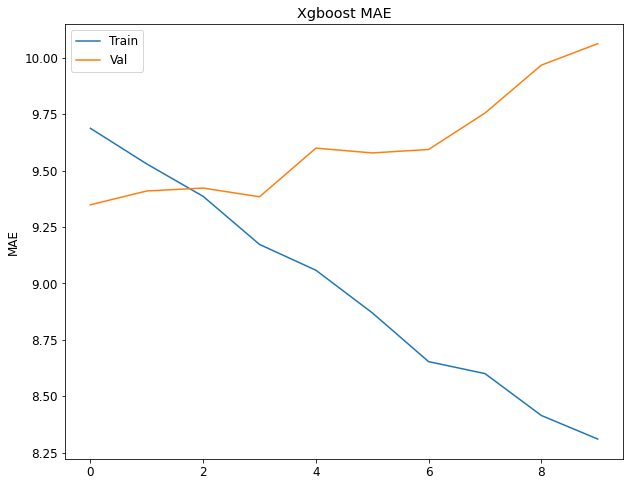

Final val score: 10.062315


In [308]:
# Split into a train and validation set
train, val = train_test_split(df_train, test_size=0.2, random_state=11)
y_train = train['total']
y_val = val['total']
X_train = train.drop(columns=['total'])
X_val = val.drop(columns=['total'])
eval_set = [(X_train, y_train), (X_val, y_val)]

params = {
    # XGBRegressor only has one objective function
    'learning_rate': 0.1,
    # length of the longest path from a root to a leaf
    'max_depth': 7,
    # subsample ratio of columns when constructing each tree
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 1000,
    'min_child_weight': 1,
    #Minimum loss reduction required to make a further partition on a leaf node of the tree.
    'gamma ': 0.1,
    # L2 Regularization
    'reg_lambda': 0.1,
    # use all possible cores for training
    'n_jobs': -1,
    'scale_pos_weight': 1
}

model = XGBRegressor(**params)
model = model.fit(X_train, y_train, eval_metric='mae', eval_set=eval_set, verbose=False, early_stopping_rounds=10)

plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 12

history = model.evals_result_
x_axis = range(len(history['validation_0']['mae']))
plt.plot(x_axis, history['validation_0']['mae'], label='Train')
plt.plot(x_axis, history['validation_1']['mae'], label='Val')
plt.legend(loc = 'best')
plt.ylabel('MAE')
plt.title('Xgboost MAE')
plt.show()

final_val_index = len(history['validation_1']['mae'])-1
print('Final val score: {}'.format(history['validation_1']['mae'][final_val_index]))


In [296]:
# Train model on all data for prediction
y_train = df_train['total']
X_train = df_train.drop(columns=['total'])
X_test = df_test

params = {
    'learning_rate': 0.1,
    'max_depth': 7,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 1000,
    'min_child_weight': 1,
    'gamma ': 0.1,
    'reg_lambda': 0.01,
    'n_jobs': -1,
    'scale_pos_weight': 1
}

model = XGBRegressor(**params)
model = model.fit(X_train, y_train)

[10:05:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [297]:
Y_hat = model.predict(df_test).tolist()
create_predictions(Y_hat)

(6914, 116)


In [250]:
'''
Start models with reduced dimension
'''
PATH = './data_current/'
TRAIN_FILE = 'XYtr_updated_reduced_dim1.csv'
TEST_FILE = 'Xte_updated_reduced_dim1.csv'
PRED_FILE = 'pred.csv'
df_train = pd.read_csv(PATH + TRAIN_FILE, index_col='id')
df_test = pd.read_csv(PATH + TEST_FILE, index_col='id')
df_preds = pd.read_csv(PATH + PRED_FILE, index_col='id')



In [159]:
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['total'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='mae', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['total'], eval_metric='mae')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    print('MAE: ' + str(mean_absolute_error(dtrain['total'].values, dtrain_predictions)))


In [160]:
# Tune hyperparams using k-fold validation
predictors = [x for x in df_train.columns if x not in ['total']]
# 0.06836649148232272
model = XGBRegressor(
 learning_rate=0.1,
 n_estimators=1000,
 max_depth=7,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=-1,
 scale_pos_weight=1,
 seed=27)
modelfit(model, df_train, predictors)



[06:32:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:32:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:32:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:32:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:32:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:32:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 0.005972671175449658


In [251]:


symbol_features = [feat for feat in df_train.columns.values if feat.startswith('symbol')]
pixel_features = [feat for feat in df_train.columns.values if feat.startswith('pixel')]
desc_features = [feat for feat in df_train.columns.values if feat.startswith('desc')]

# df_train = df_train.drop(columns=desc_features)

y_train = df_train['total']
X_train = df_train.drop(columns=['total'])
X_test = df_test

#Normalize the data
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

scaler = StandardScaler().fit(X_test)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [266]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = SVR(kernel='linear')
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

np.mean(np.absolute(scores))


2.679118962598653

In [265]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = SVR(kernel='rbf')
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

np.mean(np.absolute(scores))

# model.fit(X_train, y_train)
# Y_hat = model.predict(X_test).tolist()
# create_predictions(Y_hat)

2.6507817759578614

In [254]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = ElasticNet(random_state=0)
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

np.mean(np.absolute(scores))

4.5765289058853496

In [264]:
cv = KFold(n_splits=5, random_state=1, shuffle=True)
model = RandomForestRegressor(n_estimators=750, max_depth=8, random_state=0)
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error',
                         cv=cv, n_jobs=-1)

np.mean(np.absolute(scores))



3.2978906858722103